In [15]:
import os
import json
import pprint
import re
import argparse
from statistics import mean
from collections import Counter, defaultdict

import numpy as np
import matplotlib.pyplot as plt


In [16]:


# Tools
sca_tools = ['Grype.txt', 'Snyk.txt', 'Trivy.txt']

# RICs
rics = ['ONOS', 'OSC']

repoWithError = []

# Packages to exclude in the RIC repos
test_package = re.compile(r'test/')
benchmark_package = re.compile(r'benchmark')
examples_package = re.compile(r'examples/')
testapplication_package = re.compile(r'testapplication/')



In [115]:

# First we normalize the results from each tool
def format_sca_tool_data(repository, tool):
    if tool == "Grype.txt":
        return formatGrype(repository)
    elif tool == "Snyk.txt":
        return formatSnyk(repository)
    elif tool == "Trivy.txt":
        return formatTrivy(repository)

# This gets all the vulnerabilities in a normalized way.
# (In a list which includes all the vulnerabilities, which are not contained in a test package)
def formatGrype(repository):
    GrypeRepo = json.loads(repository)
    vulnArray = []
    for vuln in GrypeRepo["matches"]:
        path = vuln.get("artifact").get("locations")[0].get("path")
        if test_package.search(path) is not None:
            continue
        elif benchmark_package.search(path) is not None:
            continue
        elif examples_package.search(path) is not None:
            continue
        elif testapplication_package.search(path) is not None:
            continue
        else:
            vulnArray.append(vuln)
    return vulnArray

def formatSnyk(repository):
    content = json.loads(repository)
    vulnArray = []
    if "error" not in content:
        for target in content:
            if not isinstance(target, str):
                vulnList = target.get('vulnerabilities')
                path = target.get('displayTargetFile')
                if test_package.search(path) is not None:
                    print("Snyk: Skipping:" + path)
                    continue
                elif benchmark_package.search(path) is not None:
                    print("Snyk: Skipping:" + path)
                    continue
                elif examples_package.search(path) is not None:
                    print("Snyk: Skipping:" + path)
                    continue
                elif testapplication_package.search(path) is not None:
                    print("Snyk: Skipping:" + path)
                    continue
                else:
                    for vuln in vulnList:
                        vuln.pop('semver')
                        vulnArray.append(vuln)
            else:
                if target == 'vulnerabilities':
                    vulnList = content.get('vulnerabilities')
                    path = content.get('displayTargetFile')
                    print("Snyk path: {}".format(path))
                    if test_package.search(path) is not None:
                        print("Snyk: Skipping:" + path)
                        continue
                    elif benchmark_package.search(path) is not None:
                        print("Snyk: Skipping:" + path)
                        continue
                    elif examples_package.search(path) is not None:
                        print("Snyk: Skipping:" + path)
                        continue
                    elif testapplication_package.search(path) is not None:
                        print("Snyk: Skipping:" + path)
                        continue
                    else:
                        for vuln in vulnList:
                            vuln.pop('semver')
                            vulnArray.append(vuln)
                            print("1")
    else:
        global repoWithError
        repoWithError.append(os.path.basename(content['path']))
    return vulnArray

def formatTrivy(repository):
    index = repository.find("{")
    repo = repository[index:]
    TrivyRepo = json.loads(repo)
    results = TrivyRepo.get("Results")
    vulnArray = []
    if results is not None:
        for target in results:
            path = target.get("Target")
            if test_package.search(path) is not None:
                print("Trivy: Skipping:" + path)
                continue
            elif benchmark_package.search(path) is not None:
                print("Trivy: Skipping:" + path)
                continue
            elif examples_package.search(path) is not None:
                print("Trivy: Skipping:" + path)
                continue
            else:
                vulnTarget = target.get("Vulnerabilities", [])
                if not vulnTarget:
                    continue
                for vuln in vulnTarget:
                    vuln["Path"] = path
                vulnArray.extend(vulnTarget)
    return vulnArray

def save_vulnerabilities_by_directory(vulnerabilities_by_directory, base_dir="./ONOS"):
    for directory, vulnerabilities in vulnerabilities_by_directory.items():
        clean_directory = re.sub(r'[^a-zA-Z0-9_\-]', '', directory)
        dir_path = os.path.join(base_dir, clean_directory)
        os.makedirs(dir_path, exist_ok=True)
        
        filename = "Grype.json"
        filepath = os.path.join(dir_path, filename)
        
        with open(filepath, 'w') as json_file:
            json.dump(vulnerabilities, json_file, indent=4)

def dump_scan_results(rics, sca_tools):
    scan_results = dict.fromkeys(rics)
    onos_repos = []
    osc_repos = []
    for ric in rics:
        ric_dir = "./" + ric
        if not os.path.exists(ric_dir):
            os.makedirs(ric_dir)
        for repository in sorted(os.listdir(ric_dir)):
            if ric == "ONOS":
                onos_repos.append(repository)
            elif ric == "OSC":
                osc_repos.append(repository)
    for ric in rics:
        if ric == "ONOS":
            scan_results[ric] = dict.fromkeys(onos_repos)
        elif ric == "OSC":
            scan_results[ric] = dict.fromkeys(osc_repos)
        for repository in sorted(os.listdir("./" + ric)):
            scan_results[ric][repository] = dict.fromkeys(sca_tools)
            path_to_repository = os.path.join("./" + ric, repository)
            for sca_tool_file in sorted(os.listdir(path_to_repository)):
                sca_tool_file_path = os.path.join(path_to_repository, sca_tool_file)
                with open(sca_tool_file_path) as file:
                    vuln = file.read()
                #formatted_vuln = format_sca_tool_data(vuln, sca_tool_file)
                scan_results[ric][repository][sca_tool_file] = vuln
    with open('sca_results.json', 'w') as file:
        json.dump(scan_results, file)
    print("Finished writing: " + 'sca_results.json')
    pprint.pprint(scan_results)
    return scan_results

In [96]:
with open('results-26.json', 'r') as file:
        data = file.read()


In [97]:
print("Loading data...")

formatted_data = format_sca_tool_data(data, "Grype.txt")
print(formatted_data)

Loading data...
[{'vulnerability': {'id': 'GHSA-mvff-h3cj-wj9c', 'dataSource': 'https://github.com/advisories/GHSA-mvff-h3cj-wj9c', 'namespace': 'github:language:go', 'severity': 'High', 'urls': ['https://github.com/advisories/GHSA-mvff-h3cj-wj9c'], 'description': 'Unprivileged pod using `hostPath` can side-step active LSM when it is SELinux', 'cvss': [{'version': '3.1', 'vector': 'CVSS:3.1/AV:N/AC:H/PR:H/UI:N/S:C/C:H/I:H/A:H', 'metrics': {'baseScore': 8, 'exploitabilityScore': 1.3, 'impactScore': 6}, 'vendorMetadata': {'base_severity': 'High', 'status': 'N/A'}}], 'fix': {'versions': ['1.5.9'], 'state': 'fixed'}, 'advisories': []}, 'relatedVulnerabilities': [{'id': 'CVE-2021-43816', 'dataSource': 'https://nvd.nist.gov/vuln/detail/CVE-2021-43816', 'namespace': 'nvd:cpe', 'severity': 'Critical', 'urls': ['https://github.com/containerd/containerd/commit/a731039238c62be081eb8c31525b988415745eea', 'https://github.com/containerd/containerd/issues/6194', 'https://github.com/containerd/contain

In [116]:
formatted_data = format_sca_tool_data(data, "Grype.txt")
def get_vulnerabilities_by_directory(formatted_data):
        vulnerabilities_by_directory = defaultdict(list)
        
        for vuln in formatted_data:
                path = vuln.get("artifact").get("locations")[0].get("path")
                directory = os.path.dirname(path)
                vulnerabilities_by_directory[directory].append(vuln)

        return vulnerabilities_by_directory

def save_vulnerabilities_by_directory(vulnerabilities_by_directory, base_dir="./ONOS"):
    for directory, vulnerabilities in vulnerabilities_by_directory.items():
        
        clean_directory = re.sub(r'[^a-zA-Z0-9_\-]', '', directory)
        dir_path = os.path.join(base_dir, clean_directory)
        os.makedirs(dir_path, exist_ok=True)
        
        filename = "Grype.txt"
        filepath = os.path.join(dir_path, filename)
        
        with open(filepath, 'w') as json_file:
            json.dump(vulnerabilities, json_file, separators=(',', ':'))
        
        


vulnerabilities_by_directory = get_vulnerabilities_by_directory(formatted_data)
#pprint.pprint(vulnerabilities_by_directory)
save_vulnerabilities_by_directory(vulnerabilities_by_directory)


In [131]:
save_vulnerabilities_by_directory(vulnerabilities_by_directory)
dump_scan_results(['ONOS', 'OSC'], ['Grype.txt'])

Finished writing: sca_results.json
{'ONOS': {'onos-a1t': {'Grype.txt': '[{"vulnerability":{"id":"GHSA-mvff-h3cj-wj9c","dataSource":"https://github.com/advisories/GHSA-mvff-h3cj-wj9c","namespace":"github:language:go","severity":"High","urls":["https://github.com/advisories/GHSA-mvff-h3cj-wj9c"],"description":"Unprivileged '
                                    'pod using `hostPath` can side-step active '
                                    'LSM when it is '
                                    'SELinux","cvss":[{"version":"3.1","vector":"CVSS:3.1/AV:N/AC:H/PR:H/UI:N/S:C/C:H/I:H/A:H","metrics":{"baseScore":8,"exploitabilityScore":1.3,"impactScore":6},"vendorMetadata":{"base_severity":"High","status":"N/A"}}],"fix":{"versions":["1.5.9"],"state":"fixed"},"advisories":[]},"relatedVulnerabilities":[{"id":"CVE-2021-43816","dataSource":"https://nvd.nist.gov/vuln/detail/CVE-2021-43816","namespace":"nvd:cpe","severity":"Critical","urls":["https://github.com/containerd/containerd/commit/a731039238c

{'ONOS': {'onos-a1t': {'Grype.txt': '[{"vulnerability":{"id":"GHSA-mvff-h3cj-wj9c","dataSource":"https://github.com/advisories/GHSA-mvff-h3cj-wj9c","namespace":"github:language:go","severity":"High","urls":["https://github.com/advisories/GHSA-mvff-h3cj-wj9c"],"description":"Unprivileged pod using `hostPath` can side-step active LSM when it is SELinux","cvss":[{"version":"3.1","vector":"CVSS:3.1/AV:N/AC:H/PR:H/UI:N/S:C/C:H/I:H/A:H","metrics":{"baseScore":8,"exploitabilityScore":1.3,"impactScore":6},"vendorMetadata":{"base_severity":"High","status":"N/A"}}],"fix":{"versions":["1.5.9"],"state":"fixed"},"advisories":[]},"relatedVulnerabilities":[{"id":"CVE-2021-43816","dataSource":"https://nvd.nist.gov/vuln/detail/CVE-2021-43816","namespace":"nvd:cpe","severity":"Critical","urls":["https://github.com/containerd/containerd/commit/a731039238c62be081eb8c31525b988415745eea","https://github.com/containerd/containerd/issues/6194","https://github.com/containerd/containerd/security/advisories/GHSA

In [132]:
import json
import pprint

# Define the get_cves_cvss_dependencies function
def get_cves_cvss_dependencies(sca_tool, sca_tool_data):
    cves_cvss_dependencies = []
    cves = []
    cvss = []
    packages = []
    if sca_tool == "Grype.txt":
        for vulnerability in sca_tool_data:
            if vulnerability.get("vulnerability").get("id") not in cves:
                cves.append(vulnerability.get("vulnerability").get("id"))
                cvss_info = vulnerability.get("vulnerability").get("cvss")
                if cvss_info and len(cvss_info) > 0:
                    cvss.append(cvss_info[0].get("metrics").get("baseScore"))
                else:
                    cvss.append(None)  # or handle as you prefer
                    print(f"Vulnerability without CVSS: {vulnerability.get('vulnerability').get('id')}")
                vulnerability_match_details = vulnerability.get("matchDetails")
                for match_detail in vulnerability_match_details:
                    if "package" in match_detail["searchedBy"].keys():
                        packages.append(match_detail["searchedBy"]["package"]["name"])
                    elif "Package" in match_detail["searchedBy"].keys():
                        packages.append(match_detail["searchedBy"]["Package"]["name"])
            else:
                continue
        cves_cvss_dependencies = [cves, cvss, packages]
        return cves_cvss_dependencies
    elif sca_tool == "Snyk.txt":
        for vulnerability in sca_tool_data:
            if len(vulnerability.get("identifiers").get("CVE")) == 0:
                continue
            else:
                if vulnerability.get("identifiers").get("CVE")[0] not in cves:
                    cves.append(vulnerability.get("identifiers").get("CVE")[0])
                    cvss.append(vulnerability.get("cvssScore"))
                    packages.append(vulnerability.get("moduleName"))
        cves_cvss_dependencies = [cves, cvss, packages]
        return cves_cvss_dependencies
    elif sca_tool == "Trivy.txt":
        for vulnerability in sca_tool_data:
            if vulnerability.get("VulnerabilityID") not in cves:
                if vulnerability.get("CVSS") is not None:
                    cves.append(vulnerability.get("VulnerabilityID"))
                    packages.append(vulnerability.get("PkgName"))
                    nvd = vulnerability.get("CVSS").get("nvd")
                    ghsa = vulnerability.get("CVSS").get("ghsa")
                    if nvd is not None:
                        cvss.append(nvd.get("V3Score"))
                        continue
                    elif ghsa is not None:
                        cvss.append(ghsa.get("V3Score"))
                        continue
                else:
                    print(f"Vulnerability without CVSS: {vulnerability.get('VulnerabilityID')}")
                    continue
        cves_cvss_dependencies = [cves, cvss, packages]
        return cves_cvss_dependencies
    else:
        print("Unknown tool")
    return cves_cvss_dependencies

# Loading the sca_results.json and calling get_cves_cvss_dependencies
with open('sca_results.json', 'r') as file:
    sca_results = json.load(file)

# Specify the RIC, repository, and tool you want to analyze
ric = "ONOS"  # Replace with the actual RIC you are interested in
repository = "onos-a1t"  # Replace with your repository name
tool = "Grype.txt"  # Replace with the actual tool name you are analyzing

# Extract the relevant data from the JSON
sca_tool_data_str = sca_results[ric][repository][tool]

# Parse the extracted JSON string
sca_tool_data = json.loads(sca_tool_data_str)

# Call the function with the parsed data
result = get_cves_cvss_dependencies(tool, sca_tool_data)
print(result)


Vulnerability without CVSS: GHSA-7ww5-4wqc-m92c
Vulnerability without CVSS: GHSA-c9cp-9c75-9v8c
Vulnerability without CVSS: GHSA-6xv5-86q9-7xr8
Vulnerability without CVSS: GHSA-xmmx-7jpf-fx42
Vulnerability without CVSS: GHSA-jq35-85cj-fj4p
Vulnerability without CVSS: GHSA-8r3f-844c-mc37
Vulnerability without CVSS: GHSA-jw44-4f3j-q396
[['GHSA-mvff-h3cj-wj9c', 'GHSA-crp2-qrr5-8pq7', 'GHSA-hmfx-3pcx-653p', 'GHSA-7ww5-4wqc-m92c', 'GHSA-5ffw-gxpp-mxpf', 'GHSA-2qjp-425j-52j9', 'GHSA-259w-8hf6-59c2', 'GHSA-c9cp-9c75-9v8c', 'GHSA-5j5w-g665-5m35', 'GHSA-6xv5-86q9-7xr8', 'GHSA-99pg-grm5-qq3v', 'GHSA-hqxw-f8mx-cpmw', 'GHSA-qq97-vm5h-rrhg', 'GHSA-j249-ghv5-7mxv', 'GHSA-232p-vwff-86mp', 'GHSA-xw73-rw38-6vjc', 'GHSA-xmmx-7jpf-fx42', 'GHSA-mq39-4gv4-mvpx', 'GHSA-jq35-85cj-fj4p', 'GHSA-6wrf-mxfj-pf5p', 'GHSA-6hwg-w5jg-9c6x', 'GHSA-3fwx-pjgw-3558', 'GHSA-33pg-m6jh-5237', 'GHSA-2mm7-x5h6-5pvq', 'GHSA-v994-f8vw-g7j4', 'GHSA-crxj-hrmp-4rwf', 'GHSA-77vh-xpmg-72qh', 'GHSA-xr7r-f8xq-vfvv', 'GHSA-vpvm-3wq2-2w

In [127]:
with open('sca_results.json', 'r') as file:
    sca_results = json.load(file)
exm = sca_results["ONOS"]["onos-a1t"]["Grype.txt"]   
print(exm) 
cves_cvss_dependencies = get_cves_cvss_dependencies("Grype.txt", exm)
#get_cves_cvss_dependencies("Grype.txt", sca_results["ONOS"]["onos-a1t"]["Grype.txt"])

[{"vulnerability":{"id":"GHSA-mvff-h3cj-wj9c","dataSource":"https://github.com/advisories/GHSA-mvff-h3cj-wj9c","namespace":"github:language:go","severity":"High","urls":["https://github.com/advisories/GHSA-mvff-h3cj-wj9c"],"description":"Unprivileged pod using `hostPath` can side-step active LSM when it is SELinux","cvss":[{"version":"3.1","vector":"CVSS:3.1/AV:N/AC:H/PR:H/UI:N/S:C/C:H/I:H/A:H","metrics":{"baseScore":8,"exploitabilityScore":1.3,"impactScore":6},"vendorMetadata":{"base_severity":"High","status":"N/A"}}],"fix":{"versions":["1.5.9"],"state":"fixed"},"advisories":[]},"relatedVulnerabilities":[{"id":"CVE-2021-43816","dataSource":"https://nvd.nist.gov/vuln/detail/CVE-2021-43816","namespace":"nvd:cpe","severity":"Critical","urls":["https://github.com/containerd/containerd/commit/a731039238c62be081eb8c31525b988415745eea","https://github.com/containerd/containerd/issues/6194","https://github.com/containerd/containerd/security/advisories/GHSA-mvff-h3cj-wj9c","https://github.com/

AttributeError: 'str' object has no attribute 'get'

In [133]:
with open('sca_results.json', 'r') as file:
    sca_results = json.load(file)

# Specify the RIC, repository, and tool you want to analyze
ric = "ONOS"  # Replace with the actual RIC you are interested in
repository = "onos-a1t"  # Replace with your repository name
tool = "Grype.txt"  # Replace with the actual tool name you are analyzing

# Extract the relevant data from the JSON
sca_tool_data_str = sca_results[ric][repository][tool]

# Parse the extracted JSON string
sca_tool_data = json.loads(sca_tool_data_str)

# Call the function with the parsed data
result = get_cves_cvss_dependencies(tool, sca_tool_data)
print(result)

Vulnerability without CVSS: GHSA-7ww5-4wqc-m92c
Vulnerability without CVSS: GHSA-c9cp-9c75-9v8c
Vulnerability without CVSS: GHSA-6xv5-86q9-7xr8
Vulnerability without CVSS: GHSA-xmmx-7jpf-fx42
Vulnerability without CVSS: GHSA-jq35-85cj-fj4p
Vulnerability without CVSS: GHSA-8r3f-844c-mc37
Vulnerability without CVSS: GHSA-jw44-4f3j-q396
[['GHSA-mvff-h3cj-wj9c', 'GHSA-crp2-qrr5-8pq7', 'GHSA-hmfx-3pcx-653p', 'GHSA-7ww5-4wqc-m92c', 'GHSA-5ffw-gxpp-mxpf', 'GHSA-2qjp-425j-52j9', 'GHSA-259w-8hf6-59c2', 'GHSA-c9cp-9c75-9v8c', 'GHSA-5j5w-g665-5m35', 'GHSA-6xv5-86q9-7xr8', 'GHSA-99pg-grm5-qq3v', 'GHSA-hqxw-f8mx-cpmw', 'GHSA-qq97-vm5h-rrhg', 'GHSA-j249-ghv5-7mxv', 'GHSA-232p-vwff-86mp', 'GHSA-xw73-rw38-6vjc', 'GHSA-xmmx-7jpf-fx42', 'GHSA-mq39-4gv4-mvpx', 'GHSA-jq35-85cj-fj4p', 'GHSA-6wrf-mxfj-pf5p', 'GHSA-6hwg-w5jg-9c6x', 'GHSA-3fwx-pjgw-3558', 'GHSA-33pg-m6jh-5237', 'GHSA-2mm7-x5h6-5pvq', 'GHSA-v994-f8vw-g7j4', 'GHSA-crxj-hrmp-4rwf', 'GHSA-77vh-xpmg-72qh', 'GHSA-xr7r-f8xq-vfvv', 'GHSA-vpvm-3wq2-2w

In [134]:
import json
import pprint

def extract_cves(sca_results):
    # Initialize the dictionary to store CVE and CVSS dependencies
    sca_cvecvss_dependencies = dict.fromkeys(rics)
    
    print("Finished reading the SCA results data.")
    
    for ric in sca_results.keys():
        # Create repos as keys
        sca_cvecvss_dependencies[ric] = dict.fromkeys(sca_results[ric].keys())
        for repository in sca_results[ric].keys():
            sca_cvecvss_dependencies[ric][repository] = dict.fromkeys(sca_results[ric][repository].keys())
            print(repository)
            for sca_tool in sca_results[ric][repository].keys():
                sca_tool_data_str = sca_results[ric][repository][sca_tool]
                sca_tool_data = json.loads(sca_tool_data_str)
                sca_cvecvss_dependencies[ric][repository][sca_tool] = get_cves_cvss_dependencies(sca_tool, sca_tool_data)
                print("Comparing length of CVE and CVSS lists.\n"
                      "RIC: {}, Repository: {}, SCA_Tool: {}, CVE len: {}, CVSS len: {}".format(
                          ric, repository, sca_tool,
                          len(sca_cvecvss_dependencies[ric][repository][sca_tool][0]), 
                          len(sca_cvecvss_dependencies[ric][repository][sca_tool][1])
                      ))
                if len(sca_cvecvss_dependencies[ric][repository][sca_tool][0]) != len(sca_cvecvss_dependencies[ric][repository][sca_tool][1]):
                    print("More CVSS than CVE")
    
    print("Printing sca_cvecvss_dependencies results...")
    pprint.pprint(sca_cvecvss_dependencies)
    
    # Return the results dictionary
    return sca_cvecvss_dependencies

# Example usage with loaded SCA results
with open('sca_results.json', 'r') as file:
    sca_results = json.load(file)

sca_cvecvss_dependencies_results = extract_cves(sca_results)

# Optionally, you can save the results to a JSON file
with open('sca_cvecvss_dependencies_results.json', 'w') as file:
    json.dump(sca_cvecvss_dependencies_results, file)
print("Finished writing: sca_cvecvss_dependencies_results.json")


Finished reading the SCA results data.
onos-a1t
Vulnerability without CVSS: GHSA-7ww5-4wqc-m92c
Vulnerability without CVSS: GHSA-c9cp-9c75-9v8c
Vulnerability without CVSS: GHSA-6xv5-86q9-7xr8
Vulnerability without CVSS: GHSA-xmmx-7jpf-fx42
Vulnerability without CVSS: GHSA-jq35-85cj-fj4p
Vulnerability without CVSS: GHSA-8r3f-844c-mc37
Vulnerability without CVSS: GHSA-jw44-4f3j-q396
Comparing length of CVE and CVSS lists.
RIC: ONOS, Repository: onos-a1t, SCA_Tool: Grype.txt, CVE len: 49, CVSS len: 49
onos-cli
Vulnerability without CVSS: GHSA-8r3f-844c-mc37
Comparing length of CVE and CVSS lists.
RIC: ONOS, Repository: onos-cli, SCA_Tool: Grype.txt, CVE len: 8, CVSS len: 8
onos-config
Vulnerability without CVSS: GHSA-8r3f-844c-mc37
Comparing length of CVE and CVSS lists.
RIC: ONOS, Repository: onos-config, SCA_Tool: Grype.txt, CVE len: 8, CVSS len: 8
onos-e2t
Vulnerability without CVSS: GHSA-8r3f-844c-mc37
Comparing length of CVE and CVSS lists.
RIC: ONOS, Repository: onos-e2t, SCA_Tool: 

In [5]:

import json
import pprint

def count_cves(cve_data):
    print("Going to count CVEs per repo and per RIC")

    # Initialize the dictionary to store CVE counts per RIC
    ric_cves = dict.fromkeys(rics)

    for ric in cve_data.keys():
        total_ric_cves = []
        for repository in cve_data[ric].keys():
            total_repo_cves = []
            for sca_tool in cve_data[ric][repository].keys():
                if sca_tool == "Scantist.json":
                    continue
                else:
                    print("RIC: {}, Repository: {}, SCA Tool: {}, total CVE Count: {}".format(
                        ric, repository, sca_tool, len(cve_data[ric][repository][sca_tool][0])
                    ))
                    # Append only unique CVEs to count total unique vulnerabilities for a repository
                    for cve in cve_data[ric][repository][sca_tool][0]:
                        if cve not in total_repo_cves:
                            total_repo_cves.append(cve)
            print("RIC: {}, Repository: {}, Total Repo CVEs: {}".format(ric, repository, len(total_repo_cves)))
            total_ric_cves.extend(total_repo_cves)
        ric_cves[ric] = total_ric_cves
    
    pprint.pprint(ric_cves)
    for ric in ric_cves.keys():
        print("RIC: {}, Total unique CVEs: {}".format(ric, len(ric_cves[ric])))

# Example usage with provided CVE data
with open('sca_cvecvss_dependencies_results.json', 'r') as file:
    cve_data = json.load(file)

count_cves(cve_data)


Going to count CVEs per repo and per RIC
RIC: ONOS, Repository: onos-a1t, SCA Tool: Grype.txt, total CVE Count: 49
RIC: ONOS, Repository: onos-a1t, Total Repo CVEs: 49
RIC: ONOS, Repository: onos-cli, SCA Tool: Grype.txt, total CVE Count: 8
RIC: ONOS, Repository: onos-cli, Total Repo CVEs: 8
RIC: ONOS, Repository: onos-config, SCA Tool: Grype.txt, total CVE Count: 8
RIC: ONOS, Repository: onos-config, Total Repo CVEs: 8
RIC: ONOS, Repository: onos-e2t, SCA Tool: Grype.txt, total CVE Count: 8
RIC: ONOS, Repository: onos-e2t, Total Repo CVEs: 8
RIC: ONOS, Repository: onos-kpimon, SCA Tool: Grype.txt, total CVE Count: 48
RIC: ONOS, Repository: onos-kpimon, Total Repo CVEs: 48
RIC: ONOS, Repository: onos-lib-go, SCA Tool: Grype.txt, total CVE Count: 1
RIC: ONOS, Repository: onos-lib-go, Total Repo CVEs: 1
RIC: ONOS, Repository: onos-operator, SCA Tool: Grype.txt, total CVE Count: 15
RIC: ONOS, Repository: onos-operator, Total Repo CVEs: 15
RIC: ONOS, Repository: onos-topo, SCA Tool: Grype.

In [6]:
import json
import pprint

def per_repo_cve_count(cve_data):
    print("1. CVEs per RIC/repo/tool\n"
          "2. Total CVEs per RIC/repo with duplicates\n"
          "3. Total CVEs per RIC/repo without duplicates")
    
    # First CVEs per RIC/repo/tool
    cve_per_ric_repo_tool = dict.fromkeys(rics)
    for ric in cve_data.keys():
        cve_per_ric_repo_tool[ric] = dict.fromkeys(cve_data[ric].keys())
        for repository in cve_data[ric].keys():
            cve_per_ric_repo_tool[ric][repository] = dict.fromkeys(cve_data[ric][repository].keys())
            for sca_tool in cve_data[ric][repository].keys():
                if sca_tool == "Scantist.json":
                    continue
                else:
                    cve_per_ric_repo_tool[ric][repository][sca_tool] = len(cve_data[ric][repository][sca_tool][0])
    pprint.pprint(cve_per_ric_repo_tool)

    # Now combine the CVEs from all the tools and save two lists with_dups and without_dups
    cve_per_ric_repo = dict.fromkeys(rics)
    for ric in cve_data.keys():
        cve_per_ric_repo[ric] = dict.fromkeys(cve_data[ric].keys())
        for repository in cve_data[ric].keys():
            cve_list_with_dups = []
            cve_list_without_dups = []
            for sca_tool in cve_data[ric][repository].keys():
                if sca_tool == "Scantist.json":
                    continue
                else:
                    for cve in cve_data[ric][repository][sca_tool][0]:
                        cve_list_with_dups.append(cve)
                        if cve not in cve_list_without_dups:
                            cve_list_without_dups.append(cve)
            cve_per_ric_repo[ric][repository] = [cve_list_with_dups, cve_list_without_dups]
            print("Repository: {}".format(repository))
            print("Length with duplicates: {}".format(len(cve_list_with_dups)))
            print("Length without duplicates: {}".format(len(cve_list_without_dups)))

    return cve_per_ric_repo_tool, cve_per_ric_repo

# Example usage with provided CVE data
with open('sca_cvecvss_dependencies_results.json', 'r') as file:
    cve_data = json.load(file)

cve_per_ric_repo_tool, cve_per_ric_repo = per_repo_cve_count(cve_data)

# Optionally, you can save the results to JSON files
with open('per_ric_per_repo_per_tool_cve_count.json', 'w') as file:
    json.dump(cve_per_ric_repo_tool, file)
with open('per_ric_per_repo_cve_count.json', 'w') as file:
    json.dump(cve_per_ric_repo, file)
print("Finished writing JSON files.")


1. CVEs per RIC/repo/tool
2. Total CVEs per RIC/repo with duplicates
3. Total CVEs per RIC/repo without duplicates
{'ONOS': {'onos-a1t': {'Grype.txt': 49},
          'onos-cli': {'Grype.txt': 8},
          'onos-config': {'Grype.txt': 8},
          'onos-e2t': {'Grype.txt': 8},
          'onos-kpimon': {'Grype.txt': 48},
          'onos-lib-go': {'Grype.txt': 1},
          'onos-operator': {'Grype.txt': 15},
          'onos-topo': {'Grype.txt': 8},
          'onos-uenib': {'Grype.txt': 48}},
 'OSC': {}}
Repository: onos-a1t
Length with duplicates: 49
Length without duplicates: 49
Repository: onos-cli
Length with duplicates: 8
Length without duplicates: 8
Repository: onos-config
Length with duplicates: 8
Length without duplicates: 8
Repository: onos-e2t
Length with duplicates: 8
Length without duplicates: 8
Repository: onos-kpimon
Length with duplicates: 48
Length without duplicates: 48
Repository: onos-lib-go
Length with duplicates: 1
Length without duplicates: 1
Repository: onos-opera

In [7]:
import json
import pprint

def cvss_distribution(cvss_data):
    print("1. Print per RIC per repo per tool CVSS >= 8\n"
          "2. Print per RIC per repo CVSS >= 8")
    
    # Print total CVE and CVSS counts per RIC
    print("Going to compare CVE list and CVSS list and then count the number of CVSS")
    for ric in cvss_data.keys():
        total_cve_count = 0
        total_cvss_count = 0
        for repository in cvss_data[ric].keys():
            for sca_tool in cvss_data[ric][repository].keys():
                total_cve_count += len(cvss_data[ric][repository][sca_tool][0])
                total_cvss_count += len(cvss_data[ric][repository][sca_tool][1])
        print("RIC:{}, total_cve_count:{}, total_cvss_count:{}".format(ric, total_cve_count, total_cvss_count))

    # Initialize dictionaries for CVSS distribution
    low_cvss_per_ric_repo = dict.fromkeys(rics)
    medium_cvss_per_ric_repo = dict.fromkeys(rics)
    high_cvss_per_ric_repo = dict.fromkeys(rics)
    critical_cvss_per_ric_repo = dict.fromkeys(rics)
    cve_per_ric_repo = dict.fromkeys(rics)
    none_counter = 0
    
    for ric in cvss_data.keys():
        low_cvss_per_ric_repo[ric] = dict.fromkeys(cvss_data[ric].keys())
        medium_cvss_per_ric_repo[ric] = dict.fromkeys(cvss_data[ric].keys())
        high_cvss_per_ric_repo[ric] = dict.fromkeys(cvss_data[ric].keys())
        critical_cvss_per_ric_repo[ric] = dict.fromkeys(cvss_data[ric].keys())
        cve_per_ric_repo[ric] = dict.fromkeys(cvss_data[ric].keys())
        
        for repository in cvss_data[ric].keys():
            low_cvss_per_ric_repo[ric][repository] = dict.fromkeys(cvss_data[ric][repository].keys())
            medium_cvss_per_ric_repo[ric][repository] = dict.fromkeys(cvss_data[ric][repository].keys())
            high_cvss_per_ric_repo[ric][repository] = dict.fromkeys(cvss_data[ric][repository].keys())
            critical_cvss_per_ric_repo[ric][repository] = dict.fromkeys(cvss_data[ric][repository].keys())
            cve_per_ric_repo[ric][repository] = dict.fromkeys(cvss_data[ric][repository].keys())
            
            low_cves = []
            medium_cves = []
            high_cves = []
            critical_cves = []
            cves = []
            
            for sca_tool in cvss_data[ric][repository].keys():
                if sca_tool == "Scantist.json":
                    continue
                else:
                    for index, cvss in enumerate(cvss_data[ric][repository][sca_tool][1]):
                        cve = cvss_data[ric][repository][sca_tool][0][index]
                        if cvss is None:
                            none_counter += 1
                        elif 0.1 <= cvss <= 3.9:
                            print("Repository: {}, Tool: {}, CVE: {}, CVSS: {}".format(repository, sca_tool, cve, cvss))
                            if cve not in low_cves and cve not in medium_cves and cve not in high_cves and cve not in critical_cves:
                                low_cves.append(cve)
                            if cve not in cves:
                                cves.append(cve)
                        elif 4.0 <= cvss <= 6.9:
                            print("Repository: {}, Tool: {}, CVE: {}, CVSS: {}".format(repository, sca_tool, cve, cvss))
                            if cve not in low_cves and cve not in medium_cves and cve not in high_cves and cve not in critical_cves:
                                medium_cves.append(cve)
                            if cve not in cves:
                                cves.append(cve)
                        elif 7.0 <= cvss <= 8.9:
                            print("Repository: {}, Tool: {}, CVE: {}, CVSS: {}".format(repository, sca_tool, cve, cvss))
                            if cve not in low_cves and cve not in medium_cves and cve not in high_cves and cve not in critical_cves:
                                high_cves.append(cve)
                            if cve not in cves:
                                cves.append(cve)
                        elif 9.0 <= cvss <= 10.0:
                            print("Repository: {}, Tool: {}, CVE: {}, CVSS: {}".format(repository, sca_tool, cve, cvss))
                            if cve not in low_cves and cve not in medium_cves and cve not in high_cves and cve not in critical_cves:
                                critical_cves.append(cve)
                            if cve not in cves:
                                cves.append(cve)
            
            low_cvss_per_ric_repo[ric][repository] = [len(low_cves), low_cves]
            medium_cvss_per_ric_repo[ric][repository] = [len(medium_cves), medium_cves]
            high_cvss_per_ric_repo[ric][repository] = [len(high_cves), high_cves]
            critical_cvss_per_ric_repo[ric][repository] = [len(critical_cves), critical_cves]
            cve_per_ric_repo[ric][repository] = [len(cves), cves]
            total = len(low_cves) + len(medium_cves) + len(high_cves) + len(critical_cves)
            print("RIC: {}, Repository: {}, Total count: {}".format(ric, repository, total))
    
    print("Nonecounter: " + str(none_counter))
    
    return low_cvss_per_ric_repo, medium_cvss_per_ric_repo, high_cvss_per_ric_repo, critical_cvss_per_ric_repo, cve_per_ric_repo

# Example usage with provided CVE data
with open('sca_cvecvss_dependencies_results.json', 'r') as file:
    cvss_data = json.load(file)

low_cvss_per_ric_repo, medium_cvss_per_ric_repo, high_cvss_per_ric_repo, critical_cvss_per_ric_repo, cve_per_ric_repo = cvss_distribution(cvss_data)

# Optionally, you can save the results to JSON files
with open('per_ric_per_repo_low_cves.json', 'w') as file:
    json.dump(low_cvss_per_ric_repo, file)
with open('per_ric_per_repo_medium_cves.json', 'w') as file:
    json.dump(medium_cvss_per_ric_repo, file)
with open('per_ric_per_repo_high_cves.json', 'w') as file:
    json.dump(high_cvss_per_ric_repo, file)
with open('per_ric_per_repo_critical_cves.json', 'w') as file:
    json.dump(critical_cvss_per_ric_repo, file)
with open('per_ric_per_repo_cve_count.json', 'w') as file:
    json.dump(cve_per_ric_repo, file)
print("Finished writing JSON files.")


1. Print per RIC per repo per tool CVSS >= 8
2. Print per RIC per repo CVSS >= 8
Going to compare CVE list and CVSS list and then count the number of CVSS
RIC:ONOS, total_cve_count:193, total_cvss_count:193
RIC:OSC, total_cve_count:0, total_cvss_count:0
Repository: onos-a1t, Tool: Grype.txt, CVE: GHSA-mvff-h3cj-wj9c, CVSS: 8
Repository: onos-a1t, Tool: Grype.txt, CVE: GHSA-crp2-qrr5-8pq7, CVSS: 7.5
Repository: onos-a1t, Tool: Grype.txt, CVE: GHSA-hmfx-3pcx-653p, CVSS: 5.3
Repository: onos-a1t, Tool: Grype.txt, CVE: GHSA-5ffw-gxpp-mxpf, CVSS: 5.5
Repository: onos-a1t, Tool: Grype.txt, CVE: GHSA-2qjp-425j-52j9, CVSS: 5.7
Repository: onos-a1t, Tool: Grype.txt, CVE: GHSA-259w-8hf6-59c2, CVSS: 5.5
Repository: onos-a1t, Tool: Grype.txt, CVE: GHSA-5j5w-g665-5m35, CVSS: 3
Repository: onos-a1t, Tool: Grype.txt, CVE: GHSA-99pg-grm5-qq3v, CVSS: 5.4
Repository: onos-a1t, Tool: Grype.txt, CVE: GHSA-hqxw-f8mx-cpmw, CVSS: 7.5
Repository: onos-a1t, Tool: Grype.txt, CVE: GHSA-qq97-vm5h-rrhg, CVSS: 3
Re

In [8]:
import json
import pprint
from collections import Counter

def package_distribution_analysis(cvss_data):
    print("Analyzing package distribution...")

    # Initialize dictionaries for package distribution
    packages_per_ric_repo = dict.fromkeys(rics)
    packages_per_ric = dict.fromkeys(rics)
    
    for ric in cvss_data.keys():
        packages_per_ric_repo[ric] = dict.fromkeys(cvss_data[ric].keys())
        ric_packages = []
        
        for repository in cvss_data[ric].keys():
            packages_per_ric_repo[ric][repository] = dict.fromkeys(cvss_data[ric][repository].keys())
            packages = []
            unique_packages = []
            
            for sca_tool in cvss_data[ric][repository].keys():
                if sca_tool == "Scantist.json":
                    continue
                else:
                    for path in cvss_data[ric][repository][sca_tool][2]:
                        packages.append(path)
                        ric_packages.append(path)
                        if path not in unique_packages:
                            unique_packages.append(path)
            
            packages_per_ric_repo[ric][repository] = [{"unique_packages": len(unique_packages)}, dict(Counter(packages))]
        
        packages_per_ric[ric] = dict(Counter(ric_packages))
    
    # Sort and print package distributions
    onos = packages_per_ric["ONOS"]
    osc = packages_per_ric["OSC"]
    sorted_onos = sorted(onos.items(), key=lambda x: x[1], reverse=True)
    sorted_osc = sorted(osc.items(), key=lambda x: x[1], reverse=True)
    
    print("Sorted ONOS")
    pprint.pprint(sorted_onos)
    print("Sorted OSC")
    pprint.pprint(sorted_osc)
    
    print("Now to print per RIC per repo packages")
    pprint.pprint(packages_per_ric_repo)
    
    for ric in rics:
        for repo in packages_per_ric_repo[ric]:
            print("RIC: {}\tRepository: {}\t\tUnique packages: {}".format(ric, repo, packages_per_ric_repo[ric][repo][0]["unique_packages"]))
    
    return packages_per_ric_repo, packages_per_ric

# Example usage with provided CVE data
with open('sca_cvecvss_dependencies_results.json', 'r') as file:
    cvss_data = json.load(file)

packages_per_ric_repo, packages_per_ric = package_distribution_analysis(cvss_data)

# Optionally, you can save the results to JSON files
with open('per_ric_per_repo_packages.json', 'w') as file:
    json.dump(packages_per_ric_repo, file)
with open('per_ric_packages.json', 'w') as file:
    json.dump(packages_per_ric, file)
print("Finished writing JSON files.")


Analyzing package distribution...
Sorted ONOS
[('github.com/docker/docker', 36),
 ('golang.org/x/net', 35),
 ('github.com/containerd/containerd', 27),
 ('helm.sh/helm/v3', 24),
 ('github.com/opencontainers/runc', 18),
 ('golang.org/x/crypto', 9),
 ('google.golang.org/grpc', 8),
 ('google.golang.org/protobuf', 8),
 ('gopkg.in/square/go-jose.v2', 8),
 ('github.com/docker/distribution', 6),
 ('github.com/cyphar/filepath-securejoin', 3),
 ('github.com/docker/cli', 3),
 ('github.com/opencontainers/image-spec', 3),
 ('github.com/labstack/echo/v4', 1),
 ('github.com/emicklei/go-restful', 1),
 ('golang.org/x/sys', 1),
 ('golang.org/x/text', 1),
 ('gopkg.in/yaml.v3', 1)]
Sorted OSC
[]
Now to print per RIC per repo packages
{'ONOS': {'onos-a1t': [{'unique_packages': 14},
                       {'github.com/containerd/containerd': 9,
                        'github.com/cyphar/filepath-securejoin': 1,
                        'github.com/docker/cli': 1,
                        'github.com/docker/di

In [9]:
import json

def tabulate_cvss(low_cve_data, medium_cve_data, high_cve_data, critical_cve_data):
    for ric in low_cve_data.keys():
        low_cve_count = 0
        medium_cve_count = 0
        high_cve_count = 0
        critical_cve_count = 0
        for repository in low_cve_data[ric]:
            low_cve_count += low_cve_data[ric][repository][0]
        for repository in medium_cve_data[ric]:
            medium_cve_count += medium_cve_data[ric][repository][0]
        for repository in high_cve_data[ric]:
            high_cve_count += high_cve_data[ric][repository][0]
        for repository in critical_cve_data[ric]:
            critical_cve_count += critical_cve_data[ric][repository][0]
        print("RIC: " + str(ric) + " TOTAL Low CVEs: " + str(low_cve_count))
        print("RIC: " + str(ric) + " TOTAL Medium CVEs: " + str(medium_cve_count))
        print("RIC: " + str(ric) + " TOTAL High CVEs: " + str(high_cve_count))
        print("RIC: " + str(ric) + " TOTAL Critical CVEs: " + str(critical_cve_count))

# Example usage with provided CVE data
with open('per_ric_per_repo_low_cves.json', 'r') as file:
    low_cve_data = json.load(file)
with open('per_ric_per_repo_medium_cves.json', 'r') as file:
    medium_cve_data = json.load(file)
with open('per_ric_per_repo_high_cves.json', 'r') as file:
    high_cve_data = json.load(file)
with open('per_ric_per_repo_critical_cves.json', 'r') as file:
    critical_cve_data = json.load(file)

tabulate_cvss(low_cve_data, medium_cve_data, high_cve_data, critical_cve_data)


RIC: ONOS TOTAL Low CVEs: 15
RIC: ONOS TOTAL Medium CVEs: 105
RIC: ONOS TOTAL High CVEs: 45
RIC: ONOS TOTAL Critical CVEs: 2
RIC: OSC TOTAL Low CVEs: 0
RIC: OSC TOTAL Medium CVEs: 0
RIC: OSC TOTAL High CVEs: 0
RIC: OSC TOTAL Critical CVEs: 0


In [10]:
import json

def tabulate_cve_count(cve_data):
    for ric in cve_data.keys():
        total_cve_count = 0
        for repository in cve_data[ric]:
            total_cve_count += cve_data[ric][repository][0]
        print("RIC: " + str(ric) + " TOTAL CVEs: " + str(total_cve_count))

# Example usage with provided CVE data
with open('per_ric_per_repo_cve_count.json', 'r') as file:
    cve_data = json.load(file)

tabulate_cve_count(cve_data)


RIC: ONOS TOTAL CVEs: 167
RIC: OSC TOTAL CVEs: 0


In [11]:
import os
import json
import pprint
import re
from statistics import mean
from collections import Counter

import numpy as np
import matplotlib
import matplotlib.pyplot as plt


number of repos: 9
Printing cves_per_repo
[42, 7, 7, 7, 41, 1, 14, 7, 41]
['onos-a1t',
 'onos-cli',
 'onos-config',
 'onos-e2t',
 'onos-kpimon',
 'onos-lib-go',
 'onos-operator',
 'onos-topo',
 'onos-uenib']


/var/folders/bf/3mmjdjs13x9brs6_4f89q_cr0000gn/T/ipykernel_81314/1974219246.py:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


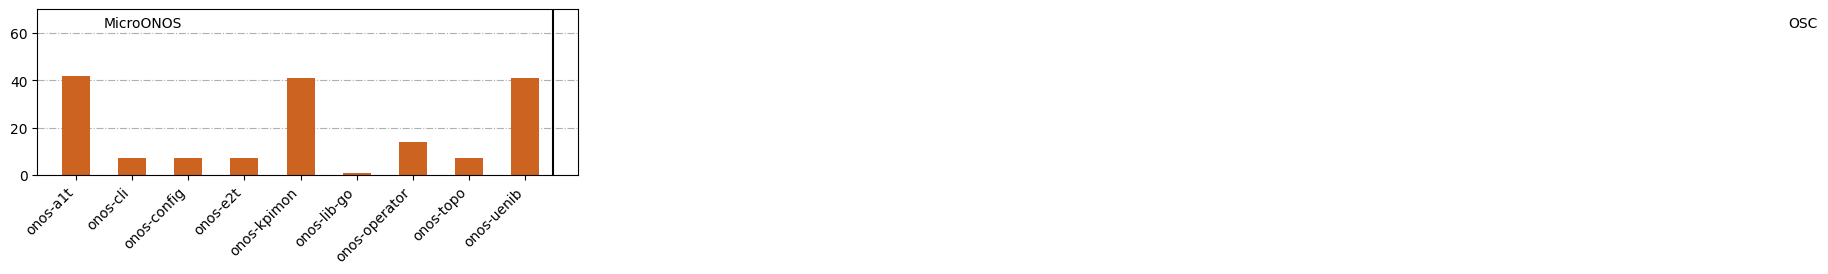

In [14]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pprint

def plot_cves(cve_data):
    # Count the number of repositories
    number_of_repositories = 0
    repositories = []
    for ric in cve_data.keys():
        number_of_repositories += len(cve_data[ric].keys())
        for repository in cve_data[ric].keys():
            repositories.append(repository)
    print("number of repos: " + str(number_of_repositories))

    cves_per_repo = []
    for ric in cve_data.keys():
        for repository in cve_data[ric]:
            cves_per_repo.append(cve_data[ric][repository][0])
    
    print("Printing cves_per_repo")
    pprint.pprint(cves_per_repo)
    pprint.pprint(repositories)

    fig = plt.figure(1, figsize=(6.974, 2.15512978986403), frameon=True)
    ax = plt.subplot(111)
    width = 0.5
    N = number_of_repositories
    ind = np.arange(N)
    colors = ['#5A5A5A', '#599487', '#CD6320', '#7EA1C5', '#7D7D7D', '#B1B1B1', '#FF9F33' ]
    rect1 = ax.bar(ind, cves_per_repo, width=width, color=colors[2], edgecolor='none', label="vulns")
    plt.ylim(0, 70)
    ax.set_xticks(ind)
    ax.set_xticklabels(tuple(repositories), rotation=45, ha='right')
    ax.yaxis.grid(True, linestyle='-.', which='major')
    ax.text(0.5, 62.6, u'MicroONOS')
    ax.text(30.5, 62.6, u'OSC')
    plt.plot([8.5, 8.5], [-1, 70], color='#000000')
    plt.tight_layout()
    ax.set_axisbelow(True)
    #plt.savefig("cve_count_repo_distribution.pdf")
    plt.show()
    # plt.close()

# Example usage with provided CVE data
with open('per_ric_per_repo_cve_count.json', 'r') as file:
    cve_data = json.load(file)

plot_cves(cve_data)
